In [1]:
%%capture

# For the demonstration, we need torchaudio and matplotlib to process example audios and visualize the spectrogram
import sys
!{sys.executable} -m pip install torchaudio soundfile matplotlib scipy

In [2]:
import os
print(os.path.exists(r"C:\Users\x\AppData\Local\Programs\Python\Python313\Lib\site-packages\audioseal"))


True


In [3]:
import torch
import torchaudio
import urllib

def download_sample_audio():
    # url = "https://keithito.com/LJ-Speech-Dataset/LJ025-0076.wav"
    url = "file:///C:/Users/x/Downloads/LJ025-0076.wav"
    with open("test.wav", "wb") as f:
        resp = urllib.request.urlopen(url)
        f.write(resp.read())
    
    wav, sample_rate = torchaudio.load("test.wav")
    return wav, sample_rate

audio, sr = download_sample_audio()
    
if sr != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
    audio = resampler(audio)
    sr = 16000

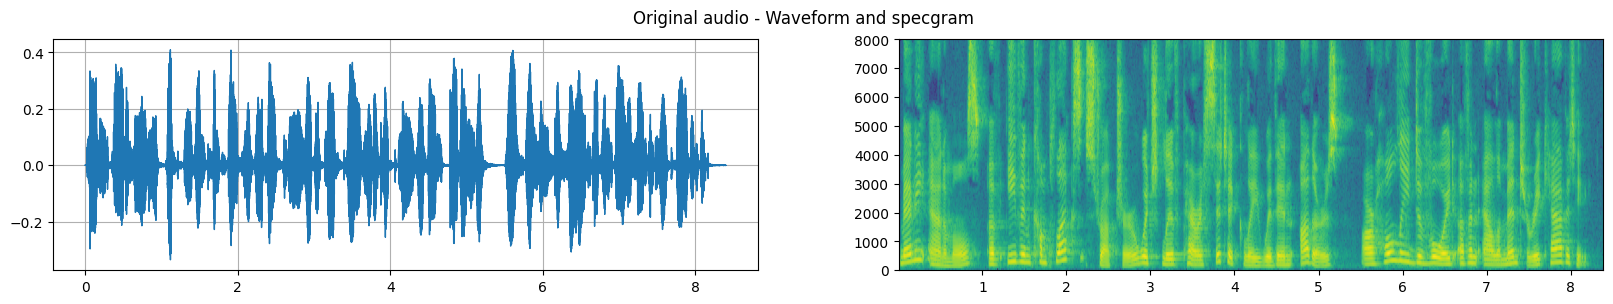

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

from notebook import play_audio, plot_waveform_and_specgram

plot_waveform_and_specgram(audio, sr, title="Original audio")

In [5]:
play_audio(audio, sr)

In [6]:
# Initialise Audioseal models
from audioseal import AudioSeal

# Load models
generator = AudioSeal.load_generator("audioseal_wm_16bits")
detector = AudioSeal.load_detector(("audioseal_detector_16bits"))


In [7]:
# Generate 4 UNIQUE messages (16-bit)
messages = [torch.randint(0, 2, (1, 16)) for _ in range(4)]

for i, msg in enumerate(messages):
    print(f"Message {i+1}: {msg.numpy().flatten()}")  # Verify uniqueness

# Initialize variables
# sr = 16000
# original_audio = torch.randn(1, 1, sr)  # Test audio (1s @16kHz)
# watermarked_audio = original_audio.clone()
# alpha = 0.5  # Reduced strength for multiple embeddings  

# # If loading real audio (e.g., from torchaudio):
# audio, sr = torchaudio.load("test.wav")
audios = audio.unsqueeze(0)  # Add batch dimension (if missing)
# audio = audio.unsqueeze(1)  # Add channel dimension (if mono)


watermarked_audio = audios.clone()  # Start with original audio

# Embed watermarks sequentially
for idx, msg in enumerate(messages):
    # Generate watermark for current message
    watermark = generator.get_watermark(watermarked_audio, sample_rate=sr)

    # Apply watermark with scaled strength
    # watermarked_audio = audios + watermark
    watermarked_audio = generator(watermarked_audio, sample_rate=sr, alpha=0.5/(idx+1))
    
    
    # Calculate metrics after EACH embedding
    noise = watermarked_audio - audios
    snr = 10 * torch.log10(audios.pow(2).mean() / noise.pow(2).mean())
    
    print(f"\nAfter Watermark {idx+1}:")
    print("-" * 50)
    print(f"  SNR: {snr:.2f} dB")

    # Detect ALL previous watermarks
    for detect_idx in range(idx+1):
        # detector.message = messages[detect_idx]  # Critical: Reset detector state
        prob, detected_msg = detector.detect_watermark(watermarked_audio,sample_rate=sr, message_threshold=0.5)
        ber = (messages[detect_idx] != detected_msg.round()).float().mean()
        print(f"  Watermark {detect_idx+1}: BER={ber:.2f}, Prob={prob:.2f}")


Message 1: [0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1]
Message 2: [0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1]
Message 3: [0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1]
Message 4: [1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0]

After Watermark 1:
--------------------------------------------------
  SNR: 33.66 dB
  Watermark 1: BER=0.50, Prob=0.95

After Watermark 2:
--------------------------------------------------
  SNR: 31.48 dB
  Watermark 1: BER=0.50, Prob=1.00
  Watermark 2: BER=0.69, Prob=1.00

After Watermark 3:
--------------------------------------------------
  SNR: 30.50 dB
  Watermark 1: BER=0.50, Prob=1.00
  Watermark 2: BER=0.69, Prob=1.00
  Watermark 3: BER=0.50, Prob=1.00

After Watermark 4:
--------------------------------------------------
  SNR: 29.94 dB
  Watermark 1: BER=0.44, Prob=1.00
  Watermark 2: BER=0.62, Prob=1.00
  Watermark 3: BER=0.44, Prob=1.00
  Watermark 4: BER=0.50, Prob=1.00


In [8]:
# Calculate SNR
noise = watermarked_audio - audios
snr = 10 * torch.log10(audios.pow(2).mean() / noise.pow(2).mean())
print(f"Final SNR: {snr:.2f} dB")

Final SNR: 29.94 dB


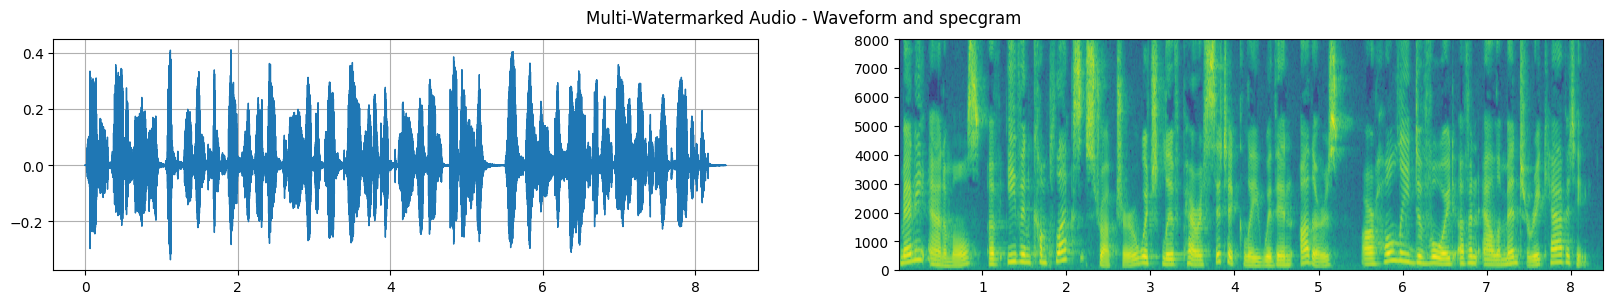

In [9]:
plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, title="Multi-Watermarked Audio")
play_audio(watermarked_audio, sr)

In [10]:
# #Detect watermarks
# def detect_watermarks(watermarked_audio, messages):
#     results = []
#     for msg in messages:
#         detector.message = msg  # Force detector to look for this message
#         prob, decoded_msg = detector.detect_watermark(watermarked_audio, sample_rate=sr)
#         ber = (msg != decoded_msg.round()).float().mean()
#         results.append((prob, ber))
#     return results

In [11]:
#apply attacks
from attacks1 import AudioEffects1 as attacks1
# Apply MP3 compression
attacked_audio = attacks.mp3_compression(watermarked_audio, bitrate=64)

# Detect after attack
attacked_results = detect_watermarks(attacked_audio, messages)
                                    
print("Compressed audio shape:", compressed_audio.shape)
                                     
print("\n--- After MP3 Compression (64 kbps) ---")
for i, (prob, ber) in enumerate(attacked_results):
    print(f"Watermark {i+1}: Detection Prob = {prob:.2f}, BER = {ber:.2f}")

SyntaxError: '(' was never closed (attacks1.py, line 19)

In [ ]:
plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, title="Multi-Watermarked Audio")
play_audio(watermarked_audio, sr)